# HPC Society - The Top 500 use case

On the top500.org website, we can find the ranks and details of the 500 most
powerful supercomputers in the world.

First, let's have a look at the most recent list and answer a few questions :
1. What manufacturers produce the world’s largest supercomputers ? And what type of processor do they use ?
   - The manufacturer for the first supercomputer of the list,[Fugaku](https://www.top500.org/system/179807/) is Fujitsu, they use their own Fujitsu ARM based processors
   - For the largest supercomputer, [Sunway Taihulight](https://www.top500.org/system/178764/) (4th in the list), which has more than 10 million cores, the manufacturer is the National Research Center of Parallel Computer Engineering & Technology (NRCPC, a national manufacturer from China's State), and they also use their own Sunway Processors.
   - Other Manufacturers are for example IBM, Lenovo, Atos, NVIDIA...

2. What fraction of peak performance is typically achieved for the LINPACK benchmark ?
   - RPeak is the maximum number of floating operation per second, according to
the theory and the cores' frequency. RMax is the achieved performance of Flop/s
using the LINPACK benchmarking.
   - For the last Top500 list, the average fraction of the theorical performance
is **62.1%**.
   - The worst fraction of the theorical FLop/s is **2.1%**, which is ridiculous.
It is done by [ThinkSystem's supercomputer](https://www.top500.org/system/179753/), from Germany.
It's theorical peak is **81 410.6** TFlop/s and it only managed to achieve
**1 741.02** TFlop/s ! It is ranked 430 in the Green500.
   - The best percentage is **94%** of the total occupancy. This great performance
is achieved by an Indian supercomputer, [Pratyush](https://www.top500.org/system/179416/).
It has a theorical peak of **4 006.2** TFlop/s and uses [Intel Xeon E5](https://ark.intel.com/content/www/us/en/ark/products/91316/intel-xeon-processor-e52695-v4-45m-cache-2-10-ghz.html) cores. (The worse one from Germany used Xeon E7 cores.)

# Data import & preprocessing
First we are going to get all our data and clean the labels and the order of
magnitudes for some values.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import os 
import numpy as np

folder = "TOP500_2005_2021"
# folder2 = "TOP500_1993_2004"

_DS_SIZE = len([name for name in os.listdir(folder)])

#example of what clean_file does
top500_df = clean_file(folder+'/TOP500_202111.xlsx')
top500_df

,n_core,rmax,rpeak,proc_speed
0,7630848,4.420100e+08,537212000.0,2200
1,2414592,1.486000e+08,200794880.0,3070
2,1572480,9.464000e+07,125712000.0,3100
3,10649600,9.301459e+07,125435904.0,1450
4,761856,7.087000e+07,93750000.0,2450
...,...,...,...,...
495,57600,1.649110e+06,2119680.0,2300
496,57600,1.649110e+06,2119680.0,2300
497,57600,1.649110e+06,2119680.0,2300
498,57600,1.649110e+06,2119680.0,2300


Now we are going to keep the min, max, standard deviation and mean values of
each period for these values :
- Number of processors
- Speed of processors, in MHz
- RMax (GFlops/s)
- RPeak (GFlops/s)

In [ ]:
#min, max, mean, std, median
rpeaks = [[],[],[],[],[]]
rmaxs = [[],[],[],[],[]]
n_cores = [[],[],[],[],[]]
proc_speed = [[],[],[],[],[]]

tabs = [rpeaks, rmaxs, n_cores, proc_speed]
labels = ["rpeak", "rmax", "n_core", "proc_speed"]
funcs = [np.min, np.max, np.mean, np.std, np.median]

for file in os.listdir(folder) :
    df = clean_file(folder + "/" + file)

    for tab, label in zip(tabs, labels) :
        for i, f in enumerate(funcs):
            tab[i].append((f(df[label])))

Let's start for example by showing the average **number of cores** and
**cores frequency** for each period, starting in June 2005. We display these
values with more or less the standard deviation :

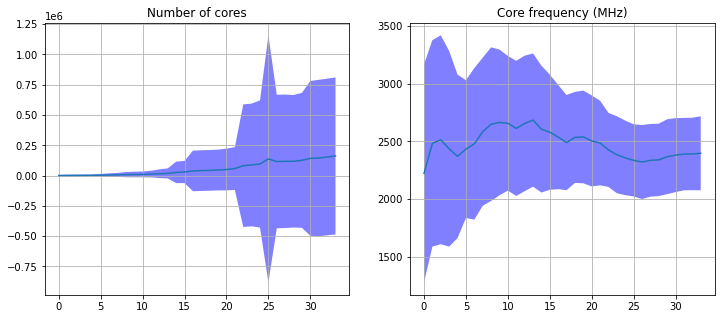

In [62]:
n_cores_np = (np.array(n_cores)) #convert to numpy arrays to plot
proc_speed_np = (np.array(proc_speed))

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(12)

ax1.set_title("Number of cores")
ax1.plot(n_cores_np[2]) #we plot the mean value
ax1.fill_between(np.arange(_DS_SIZE), #our x axis is number of the period
                 n_cores_np[2]+((n_cores_np[3])), #more the std
                 n_cores_np[2]-((n_cores_np[3])), #less the std
                 facecolor='blue', alpha=0.5)

ax2.set_title("Core frequency (MHz)")
ax2.plot(proc_speed_np[2])
ax2.fill_between(np.arange(_DS_SIZE),
                 proc_speed_np[2]+(proc_speed_np[3]),
                 proc_speed_np[2]-(proc_speed_np[3]),
                 facecolor='blue', alpha=0.5)

ax1.grid()
ax2.grid()

We can observe that around the 25th period, the average number of processors
went up, while the average frequency of processors went down. 

The relation between processors' frequency and theirs power consumption is
quadratic. Before the scientific community knew that, Intel released some very
high frequency processors, but they couldn't sell it because of the power
consumption (Xeon Phi & the [Larrabee architecture](https://en.wikipedia.org/wiki/Larrabee_(microarchitecture)#Differences_with_contemporary_GPUs),
it was also a problem of vectorial registers and cache size that were too big).

This is probably what we can observe around this 25th period in the graph. 
The average frequency dropped, but to paliate to this problem, we increased the
number of processors.

We can also see that the standard deviation is greatly increasing for the number
of cores, and decreasing for the core frequency. This also seems logical in
regards to what we just said, with the years, manufacturers have starting to
all converge towards around 2.4 GHz frequency. On the other hand, in 2005, the
minimum number of cores was **50** (most of them are around a few hundred to a
thousand) and the maximum was **65 000**. Now, the max number of cores is
**10 649 600** and the minimum is **1 664**, which is more than 4 orders of
magnitude under the maximum. This explains the standard deviation's augmentation.
Indeed, the new trend in the supercomputing world has shown that now
supercomputers tends to be **bigger** not **faster**.

# Prediction model
Now we are going to build a model in order to predict these values for the next
5 years.

For each feature : Number of cores, Frequency, RMax and RPeak, we are going to
use the median value of the top 500 list for each period. This way we get rid of
extremes values, such as China's Sunway cluster with it's 10 million cores.

## Core speed

First, let's make a simple KNeighborsRegressor to predict the **core frequency**.
Since we only have 34 records, we won't split the data into a proper test and
trainig set, but we will just hide the last value to see if our prediction
matches at least in the order of magnitude.

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

#our X is the period number, from 0 to size of folder since 1 file is 1 period
X = np.array([np.arange(_DS_SIZE-1)]).reshape(-1, 1)

#here y is the number of proc
y = np.array(proc_speed[2][:-1]) #we just hide the last lag to check our model

core_speed_knregr = make_pipeline(StandardScaler(),
                      KNeighborsRegressor(weights='distance'))
core_speed_knregr.fit(X, y)

print("Proc speed real last value : ", proc_speed[2][-1])
knregr_prediction = core_speed_knregr.predict(np.array([_DS_SIZE]).reshape(-1,1))
print("Model's estimation : ", knregr_prediction)

#Prediction of the 5 next values
lags = np.array([_DS_SIZE, _DS_SIZE+1, _DS_SIZE+2, _DS_SIZE+3, _DS_SIZE+4]).reshape(-1, 1)
core_speed_prediction = core_speed_knregr.predict(lags)

Proc speed real last value :  2396.604
Model's estimation :  [2379.4036092]


## Number of cores
To predict the number of cores, we are going to use a model a little more
complex : the Multi Layers Perceptron Regressor. Since we don't have a lot of
data, we can set a really high max_iter.

In [64]:
from sklearn.neural_network import MLPRegressor

X = np.array([np.arange(_DS_SIZE-1)]).reshape(-1, 1)

y = np.array(n_cores[2][:-1]) #[2] represents the mean value

ncore_MLPregr = MLPRegressor(hidden_layer_sizes=(50,),
                    max_iter=100000, #big max_iter because we can
                    learning_rate='adaptive', verbose=0)
ncore_MLPregr.fit(X, y)

print("Number of cores real last value : ", n_cores[2][-1])
mlp_prediction = ncore_MLPregr.predict(np.array([_DS_SIZE]).reshape(-1,1))
print("Model's estimation : ", mlp_prediction)

#Prediction of the 5 next values
lags = np.array([_DS_SIZE, _DS_SIZE+1, _DS_SIZE+2, _DS_SIZE+3, _DS_SIZE+4]).reshape(-1, 1)
ncores_prediction = ncore_MLPregr.predict(lags)

Number of cores real last value :  162520.432
Model's estimation :  [172767.01555814]


C:\conda\envs\projet-ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(


## RPeak & RMax
For the last features, we are going to work a little more on preprocessing.
We will use all the TOP500 data from 1993 to 2021. The model we are going to use
is a LinearRegression with a **PolynomialFeatures** preprocessing with a
**degree 3**. This is equivalent to a `polyfit` from numpy.

In [ ]:
folder2 = "TOP500_1993_2004"

#we'll only do the mean value for this part
rpeaks_old_mean = []
rmaxs_old_mean = []
n_cores_old_mean = []
proc_speed_old_mean = []

tabs = [rpeaks_old_mean, rmaxs_old_mean, n_cores_old_mean, proc_speed_old_mean]
labels = ["rpeak", "rmax", "n_core", "proc_speed"]

for file in os.listdir(folder2) :
    df = clean_file(folder2 + "/" + file)

    for tab, label in zip(tabs, labels) :
        tab.append(np.mean(df[label]))

rpeaks_concat = np.array(rpeaks_old_mean + rpeaks[2])
rmaxs_concat = np.array(rmaxs_old_mean + rmaxs[2])

_CONCAT_SIZE = len(rpeaks_concat)

In [66]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = np.arange(_CONCAT_SIZE-1).reshape(-1, 1)
y = np.array(rpeaks_concat[:-1])

degree=3
rpeak_polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
# rpeak_polyreg=make_pipeline(LinearRegression())
rpeak_polyreg.fit(X,y)

print("RPeak real last value : ", (rpeaks_concat[-1]))
print("Model's estimation : ", (rpeak_polyreg.predict(np.array([_CONCAT_SIZE]).reshape(-1,1))))

#5 next values
lags = np.array([_CONCAT_SIZE, _CONCAT_SIZE+1, _CONCAT_SIZE+2, _CONCAT_SIZE+3, _CONCAT_SIZE+4]).reshape(-1, 1)
print(rpeak_polyreg.predict(lags))

RPeak real last value :  9577789.88916
Model's estimation :  [9427160.60339049]
[ 9427160.60339049 10312296.62105645 11247218.64910881 12233209.53449203
 13271552.1241505 ]


In [67]:
X = np.arange(_CONCAT_SIZE-1).reshape(-1, 1)
y = np.array(rmaxs_concat[:-1])

rmax_polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
rmax_polyreg.fit(X,y)

print("RMax real last value : ", (rmaxs_concat[-1]))
print("Model's estimation : ", (rmax_polyreg.predict(np.array([_CONCAT_SIZE]).reshape(-1,1))))

#5 next values
lags = np.array([_CONCAT_SIZE, _CONCAT_SIZE+1, _CONCAT_SIZE+2, _CONCAT_SIZE+3, _CONCAT_SIZE+4]).reshape(-1, 1)
print(rmax_polyreg.predict(lags))

RMax real last value :  6073723.56754
Model's estimation :  [5922474.93953915]
[5922474.93953915 6473393.71970994 7055120.31841862 7668445.5247909
 8314160.12795247]


# Results

Moore's Law affirms taht every 18 months, the number of transistors in a chip
is multiplied by two. This leads to more speed in our cores. 

What we can observ here :
- **Core speed** : Not following Moore's law anymore, seems to have stabilized
at around 2,3 - 2,4 GHz in average.
- **Number of proc** : For this feature, on the other hand, it seems to follow
an almost-linear model. Since we cannot increase the speed of our cores, because
of the power consumption, we are going to increase the number of processors.
- **RMax & RPeak** : These are the actual values that we are interested in to
reach the exascale. 

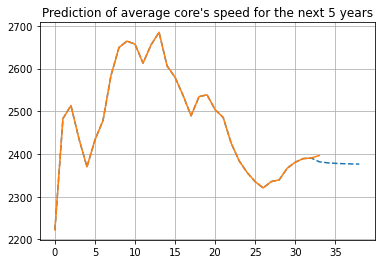

In [68]:
# lags = np.array([_DS_SIZE, _DS_SIZE+1, _DS_SIZE+2, _DS_SIZE+3, _DS_SIZE+4]).reshape(-1, 1)
lags = np.arange(_DS_SIZE+5).reshape(-1, 1)
core_speed_prediction = core_speed_knregr.predict(lags)
plt.plot(core_speed_prediction, '--')
plt.plot(proc_speed[2])
plt.title("Prediction of average core's speed for the next 5 years")
plt.grid()

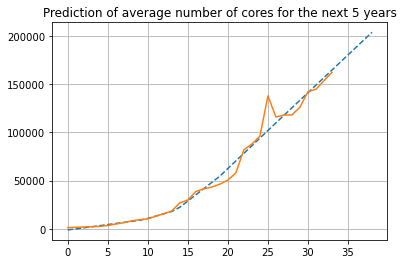

In [69]:
ncores_prediction = ncore_MLPregr.predict(lags)
plt.plot(ncores_prediction, '--')
plt.plot(n_cores[2])
plt.title("Prediction of average number of cores for the next 5 years")
plt.grid()

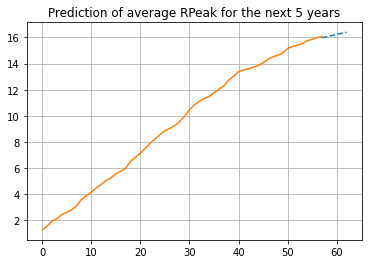

In [70]:
full_lags = np.arange(_CONCAT_SIZE + 5)
rpeak_prediction = rpeak_polyreg.predict(full_lags.reshape(-1,1))
plt.plot(np.arange(start=_CONCAT_SIZE-1, stop=_CONCAT_SIZE+5), np.log(rpeak_prediction[-6:]), '--')
plt.plot(np.log(rpeaks_concat))
plt.title("Prediction of average RPeak for the next 5 years")
plt.grid()

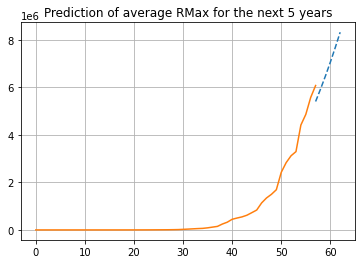

In [71]:
rmax_pred = rmax_polyreg.predict(full_lags.reshape(-1,1))
plt.plot(np.arange(start=_CONCAT_SIZE-1, stop=_CONCAT_SIZE+5), (rmax_pred[-6:]), '--')
plt.plot((rmaxs_concat))
plt.title("Prediction of average RMax for the next 5 years")
plt.grid()

These 3 last features seem to still respect Moore's law. If we keep going like
this, we will reach the (theorical) exascale in juste a few years.

# Ameliorations
- Train the model to learn the **maximum** RMax instead of the average.
- More preprocessing
- Use more features of the excels sheets